**Note**:

This Notebook is inspired by the following post:

https://practicalcheminformatics.blogspot.com/2019/11/visualizing-chemical-space.html

Created with Google Gemini v2.5 Pro

# Chemoinformatics: Chemical Space

In this notebook, we will explore the concept of chemical space.

We'll represent a set of molecules numerically using Morgan fingerprints and then use Principal Component Analysis (PCA) to reduce the high-dimensional data into a 2D plot.

This will allow us to visually identify which molecules are structurally related.

## Preparation

First, let's make sure we have the necessary libraries and set up our environment.

We'll also need the `%matplotlib` inline command to ensure our plots display correctly in Jupyter.

In [1]:
pip install rdkit networkx matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 35.1 MB/s eta 0:00:00


In [74]:
# Make sure plots appear in the notebook
%matplotlib inline

# Import necessary libraries
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time

## Define Our Molecule Dataset

Instead of a large dataset, we'll use a hand-picked set of 9 molecules.

This set includes a series of simple alcohols, some aromatic compounds, and two more complex drug molecules.

This should create some clear separation in the low-dimensional representation.

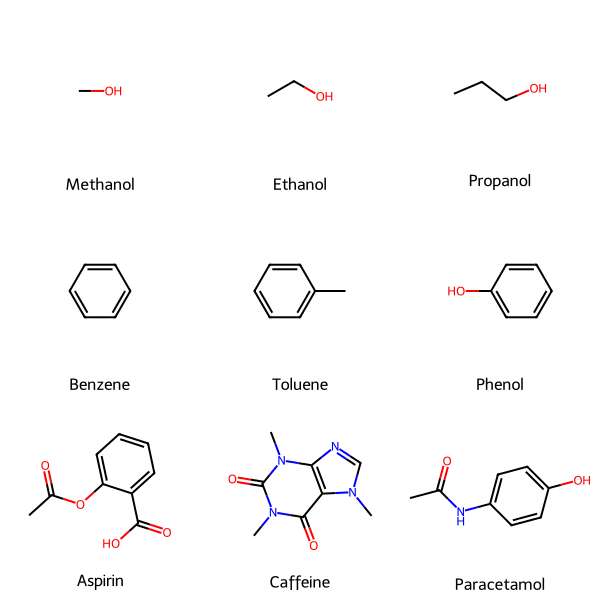

In [3]:
# A curated dictionary of molecules {name: SMILES}
molecule_dict = {
    # Alcohols
    "Methanol": "CO",
    "Ethanol": "CCO",
    "Propanol": "CCCO",

    # Aromatics
    "Benzene": "c1ccccc1",
    "Toluene": "Cc1ccccc1",
    "Phenol": "c1ccc(O)cc1",

    # Common Drugs
    "Aspirin": "CC(=O)OC1=CC=CC=C1C(=O)O",
    "Caffeine": "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",
    "Paracetamol": "CC(=O)NC1=CC=C(O)C=C1"
}

# Create RDKit molecule objects and store them
mols = [Chem.MolFromSmiles(smiles) for smiles in molecule_dict.values()]
mol_names = list(molecule_dict.keys())

# Let's see our molecules
Draw.MolsToGridImage(mols, legends=mol_names, molsPerRow=3)

## Generate Molecular Fingerprints

Now, we need to convert these chemical structures into a format a machine learning algorithm can understand: numbers.

Before we generate these numbers, it's important to understand what a molecular fingerprint is.

Think of it like a barcode for a molecule. It's a compact, digital representation that summarizes the molecule's structure. Most fingerprints are bit vectors, which are simply long arrays of 0s and 1s.

Each position (or "bit") in the array corresponds to a specific structural feature.

If the molecule has that feature, the bit is 1.

If it doesn't have the feature, the bit is 0.

This allows a computer to quickly compare molecules by just comparing their barcodes.

**Morgan Fingerprints**
We will use Morgan fingerprints (a type of circular fingerprint) for this. Each molecule will be represented as a long vector (a list of 0s and 1s) of a fixed length (e.g., 2048 bits).
<details>
<summary>Additional Information</summary>

The Morgan fingerprint, a type of **Extended-Connectivity Fingerprint (ECFP)**, is one of the most effective and widely used types. It works by identifying circular substructures around each atom.

Atom Identifiers: Initially, each atom is described by its properties (like atomic number, connections, etc.).

Iterative Growth: The algorithm then "grows" outward. In each iteration (defined by a radius), it captures a larger circular neighborhood around every atom. The identifier for this new, larger fragment includes the information from all the atoms within that radius.

Hashing and Folding: Each unique fragment identifier is processed by a "hashing function" that converts it into a number. This number determines which bit in the final vector gets switched to 1. To keep the fingerprint at a fixed length (e.g., 2048 bits), the output of the hash function is "folded" to fit within this size.
<details>

Example of Aspirin’s Morgan fingerprints, the ‘ones (1)’ and ‘zeroes (0)’ in the binary vector indicate the ‘presence’ and ‘absence’ of a defined substructure, respectively. A set of Morgan substructures is determined by the number of selected bits (e.g., 1024, 2048) and radius (r). The size of the substructure is associated with the radius

<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs12293-024-00414-6/MediaObjects/12293_2024_414_Fig3_HTML.png?as=webp" width="50%">

From: Nguyen-Vo, T.-H., Teesdale-Spittle, P., Harvey, J. E., & Nguyen, B. P. (2024). Molecular representations in bio-cheminformatics. Memetic Computing, 16(3), 519–536. https://doi.org/10.1007/s12293-024-00414-6


In [80]:
# Generate Morgan fingerprints for each molecule
# Radius 2 is standard (ECFP4), nBits is the length of the vector
fp_list = []
bitinfo_list = [] # We'll store bit info here for later analysis


# Let's time our fingerprint calculation
start_time = time.perf_counter()

# Calculate the fingerprints
for mol in mols:
    bitinfo = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, bitInfo=bitinfo)
    fp_list.append(fp)
    bitinfo_list.append(bitinfo)

end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Fingerprint calculation for {len(mols)} molecules took {elapsed_time:.4f} seconds.")

# Convert the RDKit explicit bit vectors into a NumPy array
np_fps = np.array(fp_list)

print(f"Shape of our fingerprint matrix: {np_fps.shape}")
print("This means we have 9 molecules, each described by 2048 features (bits).")

Fingerprint calculation for 9 molecules took 0.0009 seconds.
Shape of our fingerprint matrix: (9, 2048)
This means we have 9 molecules, each described by 2048 features (bits).


[08:17:10] DEPRECATION WARNING: please use MorganGenerator
[08:17:10] DEPRECATION WARNING: please use MorganGenerator
[08:17:10] DEPRECATION WARNING: please use MorganGenerator
[08:17:10] DEPRECATION WARNING: please use MorganGenerator
[08:17:10] DEPRECATION WARNING: please use MorganGenerator
[08:17:10] DEPRECATION WARNING: please use MorganGenerator
[08:17:10] DEPRECATION WARNING: please use MorganGenerator
[08:17:10] DEPRECATION WARNING: please use MorganGenerator
[08:17:10] DEPRECATION WARNING: please use MorganGenerator


We can visualize the first 12 substructures for Aspirin:

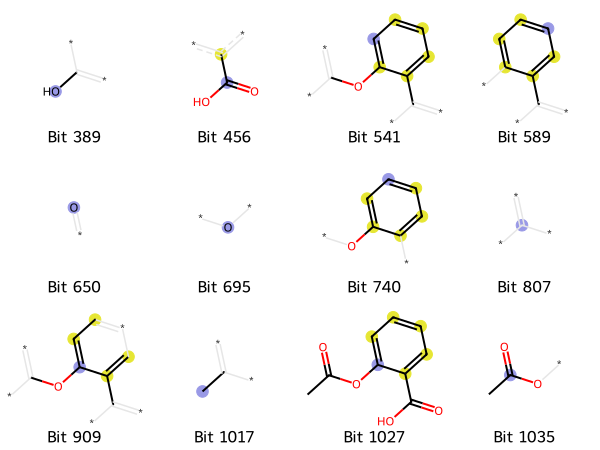

In [66]:
aspirin_mol = mols[6]
aspirin_fp = fp_list[6]
aspirin_bitinfo = bitinfo_list[6]

# Get the list of bits that are set to 1 for Aspirin
aspirin_on_bits = list(aspirin_fp.GetOnBits())

# Visualize the fragments
Draw.DrawMorganBits([(aspirin_mol, bit, aspirin_bitinfo) for bit in aspirin_on_bits[:12]],
                    molsPerRow=4,
                    legends=[f'Bit {bit}' for bit in aspirin_on_bits[:12]])



### Task 1: Fingerprints

**Investigate the effect of changing the radius when calculating the fingerprints.**

**How does the radius effect the fingerprint calculation time?**

### Question 1

What's the risk of using too few bits (e.g., nBits=512) for a large and diverse chemical library?

#### 🔍 Solution

<details>
<summary>Click here to see the solution after you've tried exploring the functions</summary>

Using too few bits increases the chance of bit collisions, where different molecular fragments get mapped to the same bit.

This makes the fingerprint less unique and can falsely suggest two different molecules are more similar than they actually are, harming model performance.

</details>

### Question 2

You're working with a dataset of small molecules (fewer than 15 heavy atoms).

How might a standard radius=2 be less effective than radius=1?

#### 🔍 Solution

<details>
<summary>Click here to see the solution after you've tried exploring the functions</summary>

A radius of 2 might generate fragments that are as large as the entire molecule itself, leading to less granular and less informative features.

A smaller radius of 1 would better capture the smaller, distinct structural differences between the molecules in the dataset.

</details>

### Question 3

You need to calculate fingerprints for 1 million molecules. How can you estimate the total runtime without running the whole job?

#### 🔍 Solution

<details>
<summary>Click here to see the solution after you've tried exploring the functions</summary>

You can benchmark a representative subset of the data.

For example, time the calculation for 1,000 molecules and then extrapolate.

If 1,000 molecules take 5 seconds, you can estimate that 1 million molecules will take approximately (1,000,000 / 1,000) * 5 seconds = 500 seconds.

</details>

## Reduce Dimensions with PCA

Our data has 2048 dimensions, which is impossible to visualize directly. We'll use Principal Component Analysis (PCA) to find the two most important "principal components" that capture the most variance in the data. This effectively projects our 2048D data down to 2D.

In [67]:
# Initialize PCA to find the top 2 principal components
pca = PCA(n_components=2)

# Fit and transform the fingerprint data
crds = pca.fit_transform(np_fps)

print(f"Shape of our new coordinate matrix: {crds.shape}")
print("The data has been successfully projected from 2048D to 2D.")

Shape of our new coordinate matrix: (9, 2)
The data has been successfully projected from 2048D to 2D.


## Inspecting the Explained Variance

Before we plot our 2D chemical space, let's check how much of the original information (variance) is captured by our two principal components. This tells us how faithfully our 2D map represents the full 2048-dimensional reality.

Variance explained by PC1: 30.61%
Variance explained by PC2: 22.35%
Total variance explained by the first two components: 52.96%


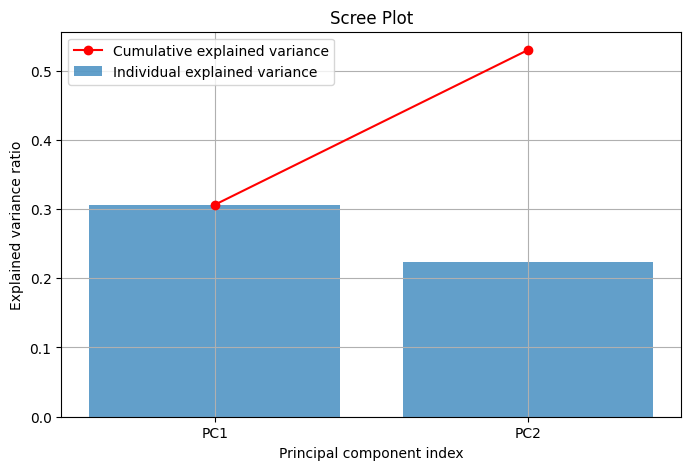

In [68]:
# The pca object stores the explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

print(f"Variance explained by PC1: {explained_variance[0]:.2%}")
print(f"Variance explained by PC2: {explained_variance[1]:.2%}")
print(f"Total variance explained by the first two components: {explained_variance.sum():.2%}")

# Create a Scree Plot to visualize the explained variance
plt.figure(figsize=(8, 5))
# Bar plot for individual variance
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.7, align='center',
        label='Individual explained variance')
# Line plot for cumulative variance
plt.plot(range(len(explained_variance)), np.cumsum(explained_variance), 'r-o',
         label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.xticks(range(len(explained_variance)), [f"PC{i+1}" for i in range(len(explained_variance))])
plt.title('Scree Plot')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Interpretation

The explained variance analysis tells you the quality of your projection.

For example, if the first two components explain 45% of the variance, it means that your 2D plot, while useful for visualization, has compressed away over half of the structural information.

The scree plot is a standard way to visualize this and helps you decide how many components you might need to retain to capture a sufficient amount of information (e.g., you might decide you need 5 components to capture 80% of the variance).

## Visualize the Chemical Space

Finally, let's create a scatter plot of our 2D data.

Each point will represent a molecule, and its position will be determined by the two principal components.

We'll label each point with the molecule's name to see how they are related.

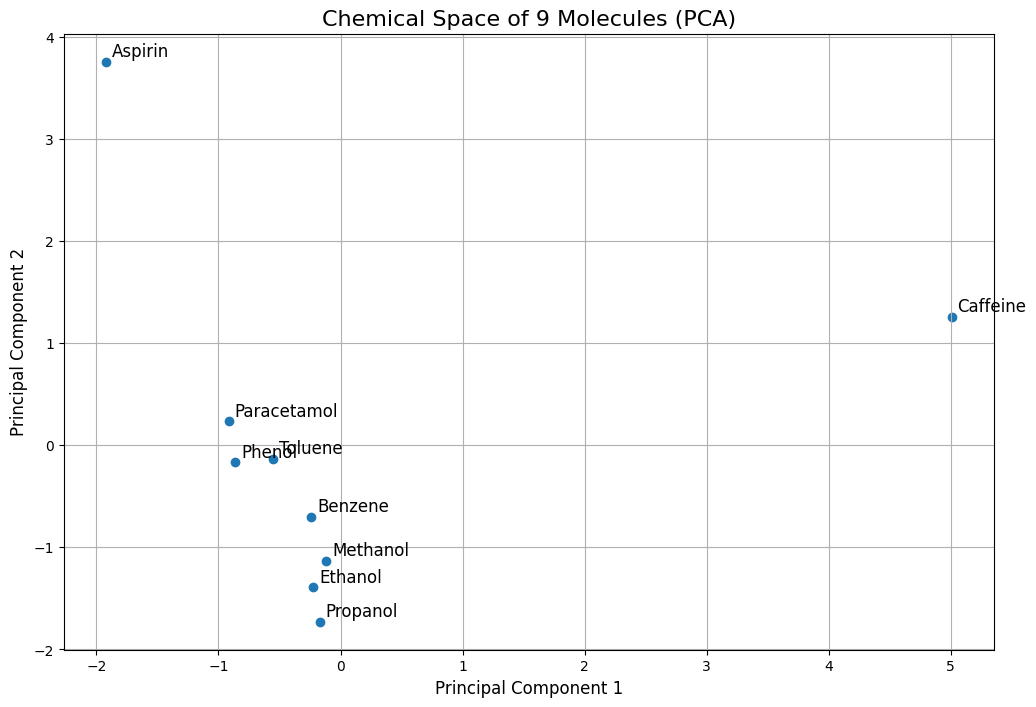

In [69]:
# Create the scatter plot
plt.figure(figsize=(12, 8))
x = crds[:, 0] # First principal component
y = crds[:, 1] # Second principal component

plt.scatter(x, y)

# Add labels to each point
for i, name in enumerate(mol_names):
    plt.text(x[i] + 0.05, y[i] + 0.05, name, fontsize=12)

# Add titles and labels
plt.title("Chemical Space of 9 Molecules (PCA)", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.grid(True)
plt.show()

### Task 2: How Trustworthy is Our 2D Map?

Look at the Plot which shows the explained variance, and then look at our final 2D Chemical Space scatter plot. We have projected 2048-dimensional data onto a simple 2D map.

**Your Tasks:**

- Critically evaluate this 2D representation. Justify the positions of the molecules by comparing its chemical structure to its neighbors and the identified important features.

- Based on the total explained variance you calculated, what percentage of the original structural information is missing from our 2D map?

- Does this 2D representation agree with your chemical expectations? Considering the information loss, why can we still be confident that the clear separation between the alcohols and the aromatics along the PC2 axis is a meaningful chemical distinction?

- The plot only shows PC1 and PC2. What do you hypothesize is the most likely structural difference being represented by PC3 (the largest source of variance not shown on our plot)?

### Question 4




The plot shows Caffeine is the most isolated molecule, pushed far out along the PC1 axis.

Identify at least two unique structural features of Caffeine that are absent in all other molecules and explain why they make it the primary outlier.

#### 🔍 Solution
<details>
<summary>Click here to see the solution after you've tried exploring the functions</summary>

**Principal Component 1 (The X-axis): The "Caffeine Axis"**

The first principal component, which explains the largest amount of variance, is overwhelmingly dominated by a single molecule: Caffeine. It is pushed far out to one side, while all other eight molecules are clustered together on the other.

This happens because Caffeine is the most structurally unique molecule in our dataset. Its **nitrogen-rich, fused heterocyclic purine ring system** is fundamentally different from the simple aliphatic alcohols and the single-ring aromatic compounds.

PC1 has therefore identified the presence of this specific scaffold as the single biggest source of variation in the entire dataset.

</details>

### Question 5

Locate Benzene, Toluene, and Phenol.

They all share a core benzene ring, yet they are spread out. Explain their specific order on the plot.

Why is Toluene much closer to Phenol than Benzene is?

#### 🔍 Solution
<details>
<summary>Click here to see the solution after you've tried exploring the functions</summary>

**The "Substituted" vs. "Unsubstituted" Effect**

Morgan fingerprints capture local atomic environments. For Toluene and Phenol, many of the generated fragments (and thus, the "on" bits in the fingerprint) will represent a "benzene ring with something attached to it." Benzene's fingerprint, in contrast, is composed entirely of fragments from an "unsubstituted benzene ring."

Because Toluene and Phenol share this core feature of being substituted, their fingerprints are more similar to each other than either is to the unsubstituted Benzene. PCA, which maximizes variance, identifies this fundamental difference as a primary axis for separating the data, thus clustering the two substituted molecules together.

**Why Toluene and Phenol Still Differ**
While grouped together, Toluene and Phenol are not in the exact same spot. The remaining distance between them is explained by the chemical nature of their unique substituents.

Toluene has a non-polar methyl group (-CH₃).

Phenol has a polar hydroxyl group (-OH), which contains a heteroatom (oxygen) and can participate in hydrogen bonding.

These distinct chemical features generate different bits in their respective fingerprints, creating a secondary source of variance that the PCA plot uses to separate them.

</details>

**In conclusion**, this is a perfect illustration of how PCA deconstructs chemical space. It first isolated the biggest outlier (Caffeine) along PC1 and then used PC2 to organize the remaining, more closely related molecules based on their most significant shared feature: the presence or absence of an aromatic ring.

## Investigating Feature Importance

The PCA plot shows us how the molecules are separated, but not why. Which specific structural features are PC1 and PC2 using to make their decisions?

To find out, we can inspect the PCA loadings. The loadings tell us how much each of our original 2048 features (the fingerprint bits) contributes to each principal component. A bit with a large loading (either positive or negative) is highly influential.

We can then visualize the substructures that correspond to these highly influential bits.

--- Top 5 Most Influential Substructures for PC1 ---
Bit 400 (from Caffeine)


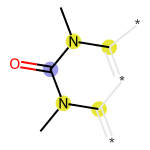

Bit 1145 (from Caffeine)


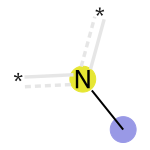

Bit 862 (from Caffeine)


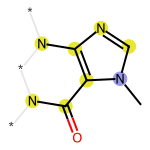

Bit 1517 (from Caffeine)


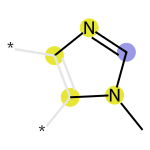

Bit 1740 (from Caffeine)


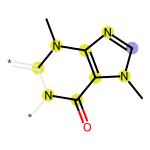

In [63]:
# The loadings are stored in pca.components_
# The shape is (n_components, n_features), so (2, 2048) in our case
loadings = pca.components_

# --- Analyze PC1 ---
pc1_loadings = loadings[0]
# Get the indices of the bits with the highest absolute influence on PC1
influential_bits_pc1 = np.argsort(np.abs(pc1_loadings))[::-1][:5] # Top 5

print("--- Top 5 Most Influential Substructures for PC1 ---")
# Find which molecule these bits came from and draw the substructures
for bit in influential_bits_pc1:
    # Find a molecule that has this bit set to 1
    for i, fp in enumerate(fp_list):
        if fp[int(bit)]:
            print(f"Bit {bit} (from {mol_names[i]})")
            display(Draw.DrawMorganBit(mols[i], int(bit), bitinfo_list[i]))
            break


--- Top 5 Most Influential Substructures for PC2 ---
Bit 650 (from Aspirin)


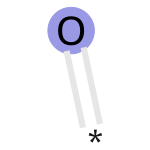

Bit 1380 (from Toluene)


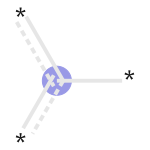

Bit 1917 (from Aspirin)


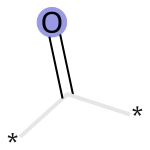

Bit 1017 (from Aspirin)


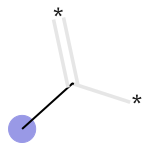

Bit 1873 (from Benzene)


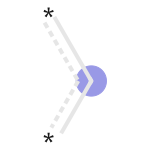

In [64]:
# --- Analyze PC2 ---
pc2_loadings = loadings[1]
# Get the indices of the bits with the highest absolute influence on PC2
influential_bits_pc2 = np.argsort(np.abs(pc2_loadings))[::-1][:5] # Top 5

print("\n--- Top 5 Most Influential Substructures for PC2 ---")
for bit in influential_bits_pc2:
    for i, fp in enumerate(fp_list):
        if fp[int(bit)]:
            print(f"Bit {bit} (from {mol_names[i]})")
            display(Draw.DrawMorganBit(mols[i], int(bit), bitinfo_list[i]))
            break

### Question 6

Why is the C=O group in caffeine identified as the most important feature in the feature importance. There are C=O groups in e.g. Aspirin and Paracetamol, while the heterocyclic C-N-C motifs are unique to caffeine?

#### 🔍 Solution
<details>
<summary>Click here to see the solution after you've tried exploring the functions</summary>
The key to understanding this result lies in remembering how Morgan fingerprints work: they encode not just an atom or a bond, but its entire local chemical environment.

**The Environment is Everything**
The C=O group in caffeine is not seen by the algorithm as just an isolated carbonyl. Instead, the fingerprint bit that is generated represents the C=O group plus the atoms it's connected to within a specific radius.

Let's compare the environments:

**Caffeine's C=O**: This carbonyl is part of a unique, electron-deficient, nitrogen-rich, fused purine ring system. The influential bit likely represents a fragment like N-C(=O)-N within that specific ring structure.

**Aspirin's C=O**: One is part of an ester (O-C(=O)-C) and the other is part of a carboxylic acid (O=C(-O)-C), both attached to a simple benzene ring.

**Paracetamol's C=O**: This one is part of an amide group (N-C(=O)-C) attached to a phenol ring.

Because the local environments are completely different, the algorithm generates different fragment identifiers for each of these C=O groups. These different identifiers are then hashed to different bits in the 2048-bit vector.

**Why C=O and not C-N-C?**
You are correct that the heterocyclic C-N-C motifs are unique to caffeine and are the reason for its separation along PC1. The feature importance analysis simply highlighted one of the most information-rich parts of that unique scaffold.

Think of it this way:

The entire purine scaffold of caffeine is what makes it an outlier.
The PCA identifies all the bits that represent fragments of this unique scaffold as important.

When we ask for the "top 5" most influential bits, it just so happens that **one of the most statistically powerful fragments within that unique scaffold is the carbonyl group in its unique purine environment**. The other influential bits shown are, as you noted, other parts of that same unique heterocyclic system.

In short,the analysis is highlighting different pieces of the same unique puzzle. The C=O bit is ranked highly not because it's a simple carbonyl, but because it's a "caffeine-flavored" carbonyl, which is a feature no other molecule in the dataset possesses.
</details>